# Lab 3: ATLAS Data Analysis
### Maria Nolan
### Teuben
### PHYS265
### May 6, 2025

In [1]:
# physical constants

# Mass of Z Boson and Uncertainty
mZ0 = 91.1880 # GeV/c^2
sigma_mZ0 = 0.0020 # GeV/c^2

# Mass of W Boson and Uncertainty
mW = 80.3692 # GeV/c^2
sigma_mW = 0.0133 # GeV/c^2

#  Mass of Higgs Boson and Uncertainty
mH = 125.20 # GeV/c^2
sigma_mH = 0.11 # GeV/c^2

#  Mass of Electron and Uncertainty
me = 0.51099895000 # MeV/c^2
sigma_me = 1.5E-10 # MeV/c^2

#  Mass of Muon and Uncertainty
mu = 105.6583755 # MeV/c^2
sigma_mu = 2.3E-6 # MeV/c^2

#  Mass of Tau and Uncertainty
mT = 1776.93 # MeV/c^2
sigma_mT = 0.09 # MeV/c^2

# Speed of Light
c = 3E8 # m/s

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chi2

## Part 1: The Invariant Mass Distribution

In [3]:
# define components of particle's momentum (Equation 1)
def four_momentum(E, pT, phi, eta):
    px = pT * np.cos(phi)
    py = pT * np.sin(phi)
    pz = pT * np.sinh(eta)
    return (E, px, py, pz)

# define invariant mass (Equation 2)
def invariant_mass(E, px, py, pz):
    p_squared  = px**2 + py**2 + pz**2
    return np.sqrt(E**2 - p_squared)

# total momentum for two particles
def invariant_mass_two(p1, p2):
    E_tot = p1[0] + p2[0]
    px_tot = p1[1] + p2[1]
    py_tot = p1[2] + p2[2]
    pz_tot = p1[3] + p2[3]
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))


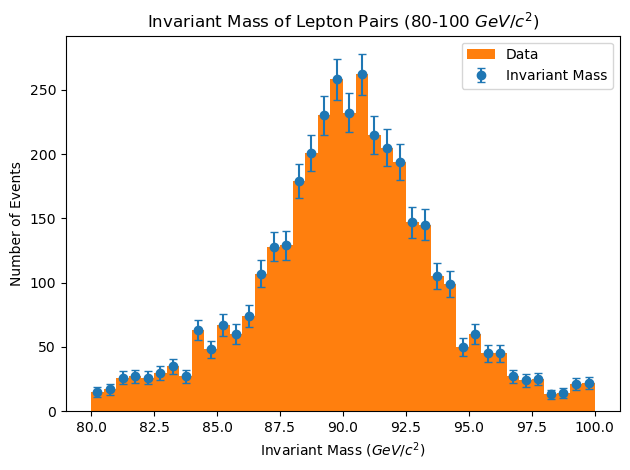

In [4]:
# Question 1: 
# load ATLAS data
import pandas as pd
data = pd.read_csv('atlas_z_to_ll.csv')

# Question 2:
# calculate vector components and four momenta
E1, px1, py1, pz1 = four_momentum(data['E1'], data['pt1'], data['phi1'], data['eta1'])
E2, px2, py2, pz2 = four_momentum(data['E2'], data['pt2'], data['phi2'], data['eta2'])

# calculate totals 
E_tot = E1 + E2
px_tot = px1 + px2
py_tot = py1 + py2
pz_tot = pz1 + pz2

# calculate total invariant mass
mass_tot = invariant_mass(E_tot, px_tot, py_tot, pz_tot)

# Question 3:
# make histogram
bins = np.linspace(80,100,41)

# calculate sigma and bin centers
N, bin_edges = np.histogram(mass_tot, bins=bins)
sigma = np.sqrt(N)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# plot errorbars and histogram
fig, ax = plt.subplots()
ax.errorbar(bin_centers, N, yerr=sigma, fmt='o', capsize=3, label='Invariant Mass')
ax.hist(mass_tot,bins, label='Data')
ax.set_xlabel(r"Invariant Mass ($GeV/c^2$)")
ax.set_ylabel("Number of Events")
ax.set_title(r"Invariant Mass of Lepton Pairs (80-100 $GeV/c^2$)")
ax.legend()
plt.tight_layout()

## Part 2: Breit-Wigner Fit

The chi-square value is: 10.0
The degrees of freedom is: 10.0
The reduced-chi-square value is: 1.0
The p-value is: 0.4
Best-fit m₀ = 90.3 ± 0.1 GeV
Best-fit Γ = 6.4 ± 0.2 GeV


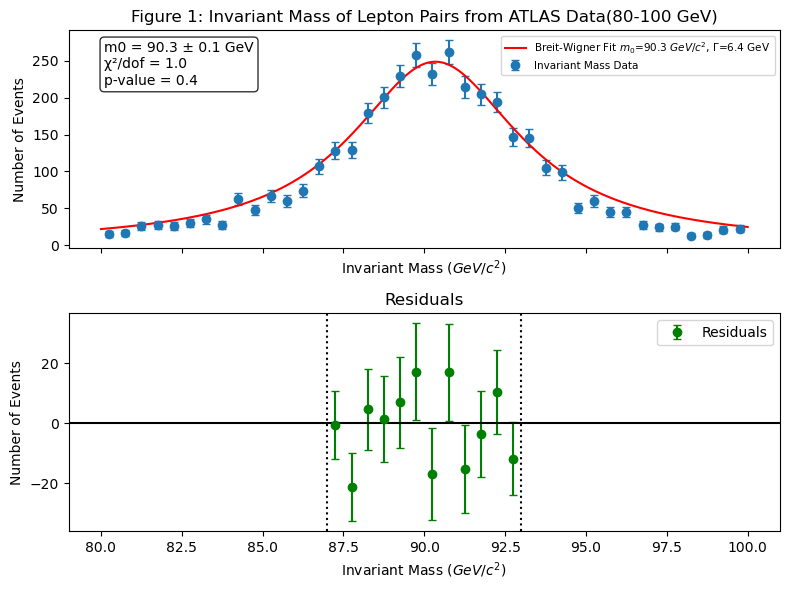

In [5]:
# Question 1:
# define Breit-Wigner equation
def decays(m, m0, gamma):
    return (1/np.pi)*((gamma/2)/((m-m0)**2 + (gamma/2)**2))

# Question 2: 
# create and apply mask
mask = (bin_centers > 87) & (bin_centers < 93)
fit_x = bin_centers[mask]
fit_y = N[mask]
fit_sigma = sigma[mask]

# apply fit
fit = 5000/2
def fitted_decays(m, m0, gamma):
    return fit * decays(m, m0, gamma)

# initial guess: m0 ~ 91.2 GeV, gamma ~ 2.5 GeV
p0 = [91.2, 2.5]

params, cov = curve_fit(fitted_decays, fit_x, fit_y, sigma=fit_sigma, p0=p0)
m0_fit, gamma_fit = params

# Question 3:
# plot fit line
x_fit = np.linspace(80,100,1000)
y_fit = fitted_decays(x_fit, *params)
fig,(ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), sharex=True)
ax1.errorbar(bin_centers, N, yerr=sigma, fmt='o', capsize=3, label='Invariant Mass Data')
ax1.set_xlabel(r"Invariant Mass ($GeV/c^2$)")
ax1.set_ylabel("Number of Events")
ax1.set_title("Figure 1: Invariant Mass of Lepton Pairs from ATLAS Data(80-100 GeV)")
ax1.plot(x_fit, y_fit, label = rf'Breit-Wigner Fit $m_0$={m0_fit:.1f} $GeV/c^2$, $\Gamma$={gamma_fit:.1f} GeV', color = 'red')
ax1.legend(fontsize=7.5)

# plot residuals
fit_values = fitted_decays(fit_x, *params)
residuals = fit_y - fit_values
ax2.errorbar(fit_x, residuals, yerr=fit_sigma, fmt='o', capsize=3, color='green', label='Residuals')
ax2.axhline(0, color='k')
ax2.axvline(87, linestyle=':', color ='k')
ax2.axvline(93, linestyle=':', color ='k')
ax2.set_xlabel(r"Invariant Mass ($GeV/c^2$)")
ax2.set_ylabel("Number of Events")
ax2.set_title("Residuals")
ax2.legend()
plt.tight_layout()
# Question 4:
# find chi-square
chi_square = np.sum((fit_y - fit_values)**2 / (fit_sigma)**2)
print(f'The chi-square value is: {chi_square:.1f}')

# find reduced-chi-square
dof = len(fit_y) - 2 # 2 fit parameters: m0 and gamma
print(f'The degrees of freedom is: {dof:.1f}')

reduced_chi_square = chi_square/dof
print(f'The reduced-chi-square value is: {reduced_chi_square:.1f}')

# find p-value
p_value = chi2.sf(chi_square, dof)
print(f'The p-value is: {p_value:.1f}')

# Question 5:
# errors
perr = np.sqrt(np.diag(cov))  # standard deviation for m₀ and Γ
m0_fit, gamma_fit = params
m0_err, gamma_err = perr

# Print results
print(f"Best-fit m₀ = {m0_fit:.1f} ± {m0_err:.1f} GeV")
print(f"Best-fit Γ = {gamma_fit:.1f} ± {gamma_err:.1f} GeV")

# Question 6:
# format output 
text = (f'm0 = {m0_fit:.1f} ± {m0_err:.1f} GeV\n'
        f'χ²/dof = {reduced_chi_square:.1f}\n'
        f'p-value = {p_value:.1f}')

# add annotations to plot
ax1.text(0.05, 0.95, text, transform=ax1.transAxes,
         verticalalignment='top', fontsize=10,
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))
plt.show()

## Part 3: 2D Parameter Contours

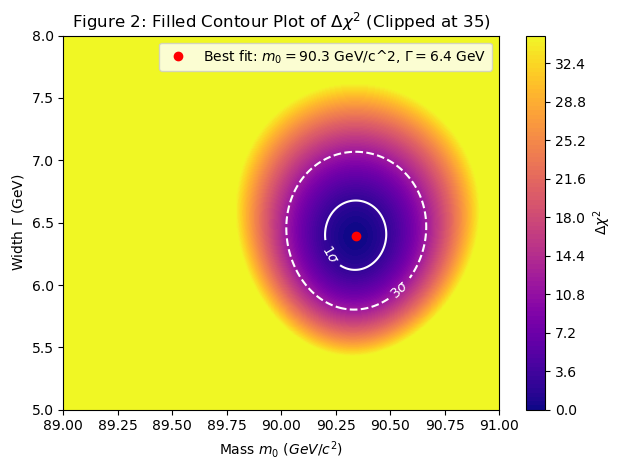

In [6]:
# Question 1:
# create 300x300 grid
m0_vals = np.linspace(89,91,300)
gamma_vals = np.linspace(5,8,300)
M0, Gamma = np.meshgrid(m0_vals, gamma_vals)

# prepare 2D array to hold chi-square values
chi2_grid = np.zeros_like(M0)

# loop through each (m0, gamma) pair
for i in range(M0.shape[0]):
    for j in range(M0.shape[1]):
        m0_try = M0[i, j]
        gamma_try = Gamma[i, j]

        model = fitted_decays(bin_centers[mask], m0_try, gamma_try)
        residuals = N[mask] - model
        chi2 = np.sum((residuals/sigma[mask])**2)
        chi2_grid[i, j] = chi2

# Quesiton 2:
# compute delta chi-square
chi2_min = np.min(chi2_grid)
delta_chi2 = chi2_grid - chi2_min

# clip delta chi-square to max of 35
delta_chi2_clipped = np.clip(delta_chi2, 0, 35)

# plot
fig, ax = plt.subplots()
contour = ax.contourf(M0, Gamma, delta_chi2_clipped, levels=100, cmap='plasma')
ax.set_xlabel('Mass $m_0$ ($GeV/c^2$)')
ax.set_ylabel('Width $\\Gamma$ (GeV)')
ax.set_title('Figure 2: Filled Contour Plot of $\\Delta \\chi^2$ (Clipped at 35)')
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label(r'$\Delta\chi^2$')
cbar.ax.set_ylim(0,35)
fig.tight_layout()

# Question 3:
levels = [2.3, 11.83] # standard for 2 parameters
cs = ax.contour(M0, Gamma, delta_chi2, levels=levels, colors='white', linestyles=['solid', 'dashed'])
ax.clabel(cs, fmt={2.3: '$1 \\sigma$', 11.83: '$3 \\sigma$'}, inline=True)

# Question 4:
ax.plot(m0_fit, gamma_fit, 'ro', label= rf'Best fit: $m_0 = {m0_fit:.1f}$ GeV/c^2, $\Gamma = {gamma_fit:.1f}$ GeV')
ax.legend()